In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, TIModel, BASENAMES, process_era5_daily_data
from MBsandbox.help_func import compute_stat, minimize_bias_geodetic, optimize_std_quot_brentq_geod

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True

# this needs to be changed if working on another computer
working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

from oggm.utils import (floatyear_to_date, date_to_floatyear)


2022-11-27 13:06:28: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-11-27 13:06:28: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-11-27 13:06:28: oggm.cfg: Multiprocessing: using all available processors (N=16)
2022-11-27 13:06:28: oggm.cfg: Multiprocessing switched ON after user settings.


In [2]:
fr = utils.get_rgi_region_file(14, version='62')
import geopandas as gpd
gdf = gpd.read_file(fr)

In [3]:
# get HEF glacier>
# df = ['RGI60-11.00897']
df = ['RGI60-14.12678']
# df = gdf.RGIId[:10]
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
gdir = gdirs[0]

2022-11-27 13:07:09: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2022-11-27 13:07:09: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2022-11-27 13:07:09: oggm.utils: /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-14/RGI60-14.12.tar verified successfully.


In [4]:
cfg.PARAMS['hydro_month_nh'] = 1
climate='W5E5'
process_w5e5_data(gdir, climate_type=climate, temporal_resol='daily', y0 = 2000)
file = gdir.get_filepath("climate_historical", filesuffix="_daily_W5E5")
ds = xr.open_dataset(file)
monthly = ds.resample(time="M").max()
monthly["month"] = monthly.time.dt.month
longterm_temps=[]
for i in range(1, 13):
    longterm_temps.append(monthly.groupby("month")[i].rolling(time=20).mean().dropna("time")["temp"].values[0])

2022-11-27 13:07:12: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2022-11-27 13:07:12: MBsandbox.mbmod_daily_oneflowline: (RGI60-14.12678) process_w5e5_data
2022-11-27 13:07:12: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc to /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc...
2022-11-27 13:14:11: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2022-11-27 13:14:11: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc to /home/bsurya/.config/OGGM/download_cache/cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019

In [19]:
ds['topo'].values

array([[5217., 5219., 5221., ..., 5591., 5594., 5593.],
       [5218., 5220., 5221., ..., 5592., 5595., 5595.],
       [5217., 5219., 5221., ..., 5594., 5597., 5596.],
       ...,
       [5524., 5524., 5528., ..., 5533., 5533., 5534.],
       [5515., 5518., 5520., ..., 5536., 5537., 5537.],
       [5507., 5510., 5511., ..., 5538., 5539., 5539.]], dtype=float32)

In [5]:
longterm_temps

[-3.8881607,
 -3.290219,
 2.788417,
 5.7272735,
 7.7375183,
 12.854057,
 16.315842,
 15.484131,
 13.575773,
 9.612305,
 3.4239058,
 -0.24785614]

In [6]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-14.12678
  Region: 14: South Asia West
  Subregion: 14-02: Karakoram                       
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.552 km2
  Lon, Lat: (77.552342005, 34.288076476)
  Grid (nx, ny): (60, 80)
  Grid (dx, dy): (20.0, -20.0)

In [7]:
df = monthly.temp.to_dataframe()
df

,temp
time,
2000-01-31,-3.191498
2000-02-29,-5.716125
2000-03-31,3.770844
2000-04-30,5.716492
2000-05-31,10.074463
...,...
2019-08-31,15.315552
2019-09-30,12.346466
2019-10-31,9.814514


In [8]:
df["month"] = df.index.strftime('%b')
df

,temp,month
time,,
2000-01-31,-3.191498,Jan
2000-02-29,-5.716125,Feb
2000-03-31,3.770844,Mar
2000-04-30,5.716492,Apr
2000-05-31,10.074463,May
...,...,...
2019-08-31,15.315552,Aug
2019-09-30,12.346466,Sep
2019-10-31,9.814514,Oct


In [9]:
df = df.loc[df.temp<0]
df

,temp,month
time,,
2000-01-31,-3.191498,Jan
2000-02-29,-5.716125,Feb
2001-01-31,-4.301331,Jan
2001-02-28,-1.687653,Feb
2002-02-28,-5.188049,Feb
2002-12-31,-0.152191,Dec
2003-01-31,-4.155212,Jan
2003-02-28,-1.247955,Feb
2003-12-31,-2.299591,Dec


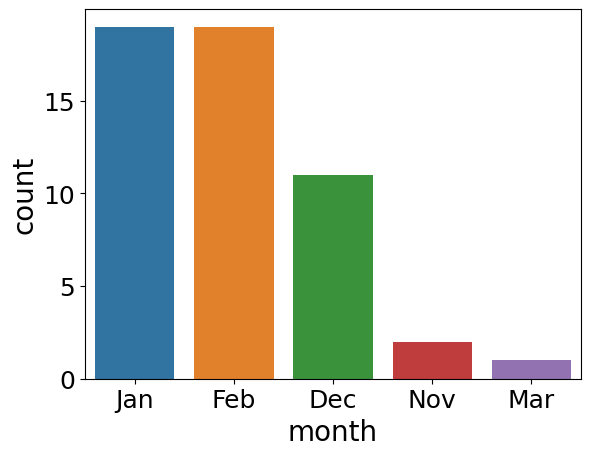

In [10]:
import seaborn as sns

ax = sns.countplot(x="month",data=df)

In [11]:
# Get the topo data and the glacier mask
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    topo = ds.topo
    # Glacier outline raster
    mask = ds.glacier_ext

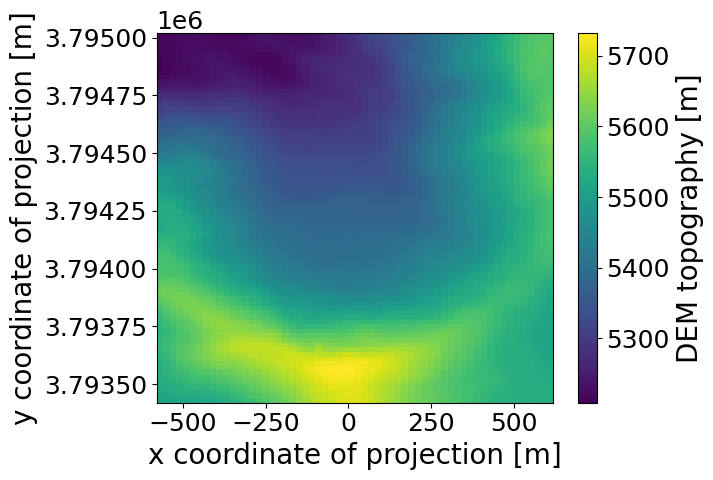

In [12]:
topo.plot();

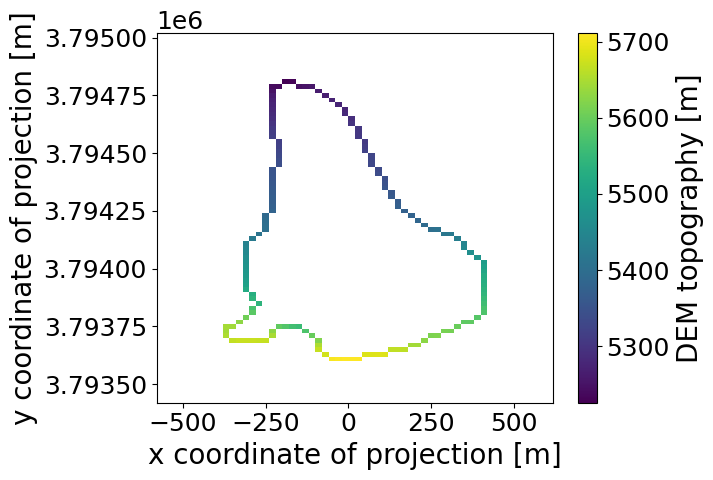

In [13]:
topo_ext = topo.where(mask==1)
topo_ext.plot();